<a href="https://colab.research.google.com/github/LordRelentless/NGFTSimulations/blob/main/Simulation_1_2_Mass_Energy_Information_Equivalence_in_Particle_Decayv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
module NGFTDecay

using Random, Printf

# Constants
const k = 1.38e-23        # Boltzmann constant
const a_U = 1e-21         # NGFT information-energy conversion
const c = 3e8             # Speed of light

# Particle Struct
mutable struct Particle
    id::Int
    mass::Float64
    velocity::Tuple{Float64, Float64}
    parent_id::Union{Int, Nothing}
    generation::Int
end

# Ledger to track all particles and events
mutable struct SimulationState
    particles::Dict{Int, Particle}
    next_id::Int
end

function SimulationState()
    return SimulationState(Dict{Int, Particle}(), 1)
end

# Calculate total energy from information
function total_information(p::Particle)
    vx, vy = p.velocity
    ke = 0.5 * p.mass * (vx^2 + vy^2)
    rest = p.mass * c^2
    info_rest = rest / ((k + 1) * a_U)
    info_kinetic = ke / ((k + 1) * a_U)
    return info_rest + info_kinetic
end

# Add particle to state
function add_particle!(state::SimulationState, p::Particle)
    state.particles[p.id] = p
    state.next_id += 1
end

# Decay rule: splits particle into two equal daughters with opposite momentum
function decay!(state::SimulationState, pid::Int)
    parent = state.particles[pid]

    m_d = parent.mass / 2
    speed = rand() * 2.0  # Randomized kinetic energy
    θ = rand() * 2π
    vx = speed * cos(θ)
    vy = speed * sin(θ)

    d1 = Particle(state.next_id, m_d, (vx, vy), parent.id, parent.generation + 1)
    add_particle!(state, d1)

    d2 = Particle(state.next_id, m_d, (-vx, -vy), parent.id, parent.generation + 1)
    add_particle!(state, d2)
end

# Run chain simulation for N generations
function run_decay_chain(generations::Int)
    state = SimulationState()
    parent = Particle(state.next_id, 4.0, (0.0, 0.0), nothing, 0)
    add_particle!(state, parent)

    for g in 1:generations
        current = [p for p in values(state.particles) if p.generation == g - 1]
        for p in current
            decay!(state, p.id)
        end
    end

    return state
end

# Audit information totals
function audit_information(state::SimulationState)
    gen_info = Dict{Int, Float64}()

    for p in values(state.particles)
        I = total_information(p)
        gen = p.generation
        gen_info[gen] = get(gen_info, gen, 0.0) + I
    end

    println("=== Informational Energy by Generation ===")
    for g in sort(collect(keys(gen_info)))
        @printf("Gen %d: %.4e bits\n", g, gen_info[g])
    end
end

# Run it
state = run_decay_chain(3)
audit_information(state)

end # module

=== Informational Energy by Generation ===
Gen 0: 3.6000e+38 bits
Gen 1: 3.6000e+38 bits
Gen 2: 3.6000e+38 bits
Gen 3: 3.6000e+38 bits


Main.NGFTDecay

In [2]:
using Pkg
Pkg.add("Graphs")
Pkg.add("GraphPlot")
Pkg.add("GraphViz")
Pkg.add("CairoMakie")
Pkg.add("GraphMakie")



   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
Precompiling packages...
   3560.0 ms  ✓ QOI
   4249.6 ms  ✓ NVTX
   1469.7 ms  ✓ xkbcommon_jll
   2977.0 ms  ✓ OpenEXR
  13543.1 ms  ✓ PlotThemes
  17965.4 ms  ✓ RecipesPipeline
   1787.4 ms  ✓ Vulkan_Loader_jll
   1479.7 ms  ✓ libdecor_jll
   2350.4 ms  ✓ Qt6Base_jll
   1499.8 ms  ✓ GLFW_jll
   1841.5 ms  ✓ Qt6ShaderTools_jll
   3160.1 ms  ✓ GR_jll
   4659.8 ms  ✓ Qt6Declarative_jll
   2463.7 ms  ✓ Qt6Wayland_jll
  13185.0 ms  ✓ GR
 117388.3 ms  ✓ TiffImages
 197603.7 ms  ✓ CUDA
  11349.9 ms  ✓ Atomix → AtomixCUDAExt
  15396.9 ms  ✓ CUDA → ChainRulesCoreExt
  16372.7 ms  ✓ CUDA → SpecialFunctionsExt
  14934.2 ms  ✓ ArrayInterface → ArrayInterfaceCUDAExt
  16911.8 ms  ✓ CUDA → EnzymeCoreExt
  15014.9 ms  ✓ NNlib → NNlibCUDAExt
  15423.9 ms  ✓ WeightInitializers → WeightInitializersCUDAExt
 230803.3 ms  ✓ Plots
   6093.1 ms  ✓ Plots → U

=== Informational Energy by Generation ===
Gen 0: 3.6000e+38 bits
Gen 1: 3.6000e+38 bits
Gen 2: 3.6000e+38 bits
Gen 3: 3.6000e+38 bits


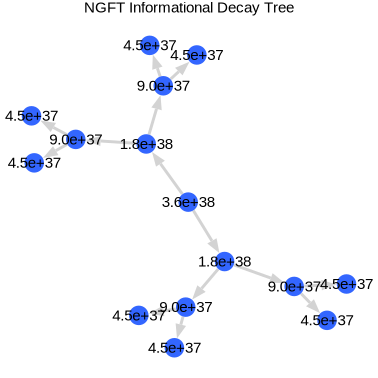

In [5]:
using Graphs, GraphPlot
using Colors # Explicitly adding again
using Printf # Added Printf

# Build graph from simulation state
function build_decay_graph(state::NGFTDecay.SimulationState) # Specify module for SimulationState
    g = DiGraph()
    labels = Dict{Int, String}()
    info = Dict{Int, Float64}()
    # Map particle id to vertex index
    id_to_vertex = Dict{Int, Int}()

    for (id, particle) in state.particles
        add_vertex!(g)
        vertex_index = nv(g)
        id_to_vertex[id] = vertex_index # Store the mapping
        labels[vertex_index] = "G$(particle.generation)"
        info[vertex_index] = NGFTDecay.total_information(particle)
    end

    for (id, particle) in state.particles
        if !isnothing(particle.parent_id)
            # Use the stored mapping to find the parent vertex index
            parent_vertex = id_to_vertex[particle.parent_id]
            child_vertex = id_to_vertex[id]
            add_edge!(g, parent_vertex, child_vertex)
        end
    end

    return g, labels, info
end

# Plot the informational decay graph
function plot_decay_tree(state::NGFTDecay.SimulationState) # Specify module for SimulationState
    g, labels, info = build_decay_graph(state)

    node_colors = [RGB(0.2, 0.4, 1.0) for _ in 1:nv(g)]
    node_labels = [@sprintf("%.1e", info[v]) for v in 1:nv(g)]

    gplot(g,
        layout=spring_layout, # Pass the function itself
        nodesize=0.2,
        title="NGFT Informational Decay Tree",
        nodelabel=node_labels, # Added back
        nodefillc=node_colors, # Added back
        # method=:tree, # Removed incorrect method argument
        # figsize=(1000, 800), # figsize is not a valid argument for gplot
    )
end

# Run and plot
state = NGFTDecay.run_decay_chain(3) # Specify module for run_decay_chain
NGFTDecay.audit_information(state) # Specify module for audit_information
plot_decay_tree(state)